In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py, cv2
from IPython.display import clear_output
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import TimeSeries, print_wise
from general_utils.dataloader import load_eyetracking_data
from image_processing.utils import read_video
from image_processing.gaze_dep_models import pad_frame, extract_square_patch

In [2]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    sub_num = 3
    fs = 50
    
cfg = Cfg()

In [3]:
run = 1
eyetracking_dir = f"{paths['data_dir']}/data/eyetracker_data"
eyetracking_file = f"{eyetracking_dir}/gaze_sub{cfg.sub_num:03d}_run{run:02d}_{cfg.fs}Hz.mat"

In [4]:
g, ts = load_eyetracking_data(paths, cfg.sub_num, run, cfg.fs, xy=True)
g.resample(23.98)    
g.set_array(np.round(g.get_array()).astype(int))

In [75]:
v = read_video(paths, 0, 1, vid_duration=80)


09:09:24 - rank 0 /Users/tizianocausin/1917_local/stimuli/Project1917_movie_part1_24Hz.mp4 read successfully


In [7]:
nframes, h, w, c = v.shape
print(h, w)

522 1280


In [63]:
43692/50

873.84

In [62]:
frame_count/23.98 - 5

873.7322768974145

In [59]:
print(frame_count -121)

20951.0


In [53]:
subs = list(range(3, 24))
subs.extend([25, 28, 30, 31, 34])
for i in [1]:#,2, 3, 4, 5, 6]:
    for sub in subs: 
        g, ts = load_eyetracking_data(paths, cfg.sub_num, i, cfg.fs, xy=True)
        # g.resample(23.98)
        print(len(g))
    

43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def extract_circular_patch(canvas, cx, cy, radius, fill_value=128):
    """
    Extract a circular patch around (cx, cy) with radius.
    Pads with fill_value if circle goes outside canvas.
    
    canvas: (H, W, C) image
    cx, cy: center coordinates (pixels)
    radius: radius of circle (pixels)
    fill_value: value to fill outside canvas
    """
    H, W, C = canvas.shape
    diameter = 2 * radius
    
    # Initialize patch with fill_value
    patch = np.ones((diameter, diameter, C), dtype=canvas.dtype) * fill_value
    
    # Compute coordinates in canvas
    x_start_canvas = max(cx - radius, 0)
    x_end_canvas   = min(cx + radius, W)
    y_start_canvas = max(cy - radius, 0)
    y_end_canvas   = min(cy + radius, H)
    
    # Compute coordinates in patch
    x_start_patch = max(0, radius - cx)
    x_end_patch   = x_start_patch + (x_end_canvas - x_start_canvas)
    y_start_patch = max(0, radius - cy)
    y_end_patch   = y_start_patch + (y_end_canvas - y_start_canvas)
    
    # Copy pixels into patch
    patch[y_start_patch:y_end_patch, x_start_patch:x_end_patch, :] = \
        canvas[y_start_canvas:y_end_canvas, x_start_canvas:x_end_canvas, :]
    
    # Create circular mask
    Y, X = np.ogrid[:diameter, :diameter]
    dist_from_center = np.sqrt((X - radius)**2 + (Y - radius)**2)
    circle_mask = dist_from_center <= radius
    
    # Apply mask: everything outside circle -> fill_value
    patch[~circle_mask] = fill_value
    circle_pixels = patch[circle_mask]
    return circle_pixels#patch


In [ ]:
def read_video(paths, rank, movie_part, vid_duration=0):
    video_path = f"{paths['data_dir']}/stimuli/Project1917_movie_part{movie_part}_24Hz.mp4" 
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video file: {video_path}")

    
    video = np.zeros((frames_to_loop, height, width, 3), dtype=np.uint8) # standard [B, H, W, C]
    counter = 0
    total = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    for frame_idx in range(frames_to_loop):
        ret, frame = cap.read()
        if not ret:
            raise RuntimeError(f"Failed to read frame {counter} from {video_path}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video[frame_idx, :, :, :] = frame
        counter += 1
    # end while True
    print_wise(f"{video_path} read successfully", rank=rank)
    cap.release()
    return video


In [29]:
sub_num = 3; run = 1; model_name = "pixelwise"; fs = 23.98
outfn = f"{paths['data_dir']}/models/sub{sub_num:03d}_run{run:02d}_{model_name}_gazedep_{sq_side}x{sq_side}rect_to_{sq_side_resized}x{sq_side_resized}_{round(fs)}Hz.h5"

In [ ]:
resized = resized.flatten(order="F")

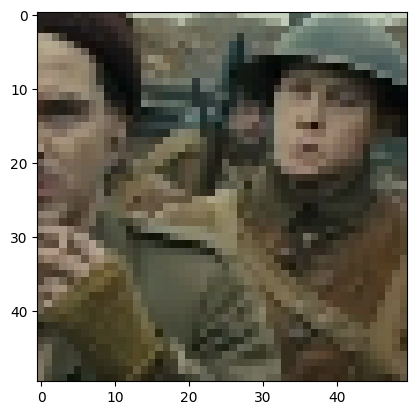

In [ ]:
plt.imshow(resized.reshape((50, 50, 3),order="F"))

In [32]:
with h5py.File(outfn, "w") as f:
    f.create_dataset("vecrep", data=resized)

In [33]:
with h5py.File(outfn, "r") as f:
    print(list(f.keys()))

['vecrep']


In [ ]:
from image_processing.utils import get_video_dimensions

In [ ]:
movie_path = f"{paths['data_dir']}/stimuli/Project1917_movie_part1_24Hz.mp4"
cap = cv2.VideoCapture(movie_path)


get_video_dimensions(cap)

(522, 1280, 21072)

In [53]:
frames_n - round(5*fps)

20832

# todo wr function that works in parallel

In [60]:
from einops import rearrange

In [114]:
def pixelwise_lum(frame_patch, features, sq_side_resized):
    resized = cv2.resize(frame_patch, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)
    resized.ravel(order='F')
    features.append(resized)
    # no need of return feats as its modified in-place

def save_pixelwise_lum(paths, model_name, sub_num, run, *args, **kwargs):
    save_name = "aa"
    return save_name

In [112]:
import time
screen_res = (1080, 1920)
gray_value = 128  # mid-gray
sq_side = 224
sq_side_resized = 50

In [113]:
def run2part(run):
    if run > 3:
        movie_part = run - 3
    else: 
        movie_part = run
    # end if run > 3:
    return movie_part 

In [ ]:
import time
from general_utils.dataloader import load_eyetracking_data

def sequential_gaze_dep_loop(xy_gaze, frame_idx, sq_side, offset_dims, canvas, features, func, rank, *args, **kwargs):
    xy = xy_gaze[frame_idx]
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError(f"Failed to read frame {frame_idx} from {movie_path}")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    canvas = pad_frame(frame, (h,w), offset_dims, canvas=None)
    frame_patch = extract_square_patch(canvas, xy[0], xy[1], sq_side)
    func(frame_patch, features, *args, **kwargs)
    if frame_idx %1000 == 0: # to print out
        print_wise(f"processed first {frame_idx}th frames", rank=rank)
    # end if frame_idx %1000 == 0:

def sequential_gaze_dep_mod(paths, rank, func, save_func, sq_side, model_name, sub_num, run, fs, *args, screen_res=(1080, 1920), secs_to_skip=5, **kwargs): 
    save_name = save_func(paths, model_name, sub_num, run, *args, **kwargs)
    if os.path.exists(save_name):
        print_wise(f"model already exists at {save_name}", rank=rank)
        return None
    # end if os.path.exists(save_name):
    xy_gaze = load_eyetracking_data(paths, sub_num, run, fs, xy=True)
    movie_part = run2part(run)
    cap = cv2.VideoCapture(f"{paths['data_dir']}/stimuli/Project1917_movie_part{movie_part}_24Hz.mp4")
    h, w, frames_n = get_video_dimensions(cap)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames_n -= round(secs_to_skip*fps)
    offset_dims = ((screen_res[0] -h)//2 , ( screen_res[1] - w)//2)
    cap.set(cv2.CAP_PROP_POS_FRAMES, round(5*fps)-1)
    canvas = None
    features = []
    for frame_idx in range(frames_n):
        canvas = sequential_gaze_dep_loop(xy_gaze, frame_idx, sq_side, offset_dims, canvas, features, func, rank, *args, **kwargs)
    # end for frame_idx in range(frames_n):
    
    features = np.stack(features, axis=1)
    with h5py.File(save_name, "w") as f:
        f.create_dataset("vecrep", data=features)
    # end with h5py.File(save_name, "w") as f:
# EOF



# TODO make function work and run it on the cluster + commit 

In [119]:
rank = 0; 
sequential_gaze_dep_mod(paths, rank, pixelwise_lum, save_pixelwise_lum, sq_side, model_name, sub_num, run, 50, *(50,), screen_res=(1080, 1920), secs_to_skip=5)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [95]:
for i in range(feats.shape[1]):
    f = np.reshape(feats[:, i], (sq_side_resized, sq_side_resized, 3), order='F')
    plt.imshow(f)
    clear_output(wait=True)
    plt.show()
    # time.sleep(0.01)

KeyboardInterrupt: 

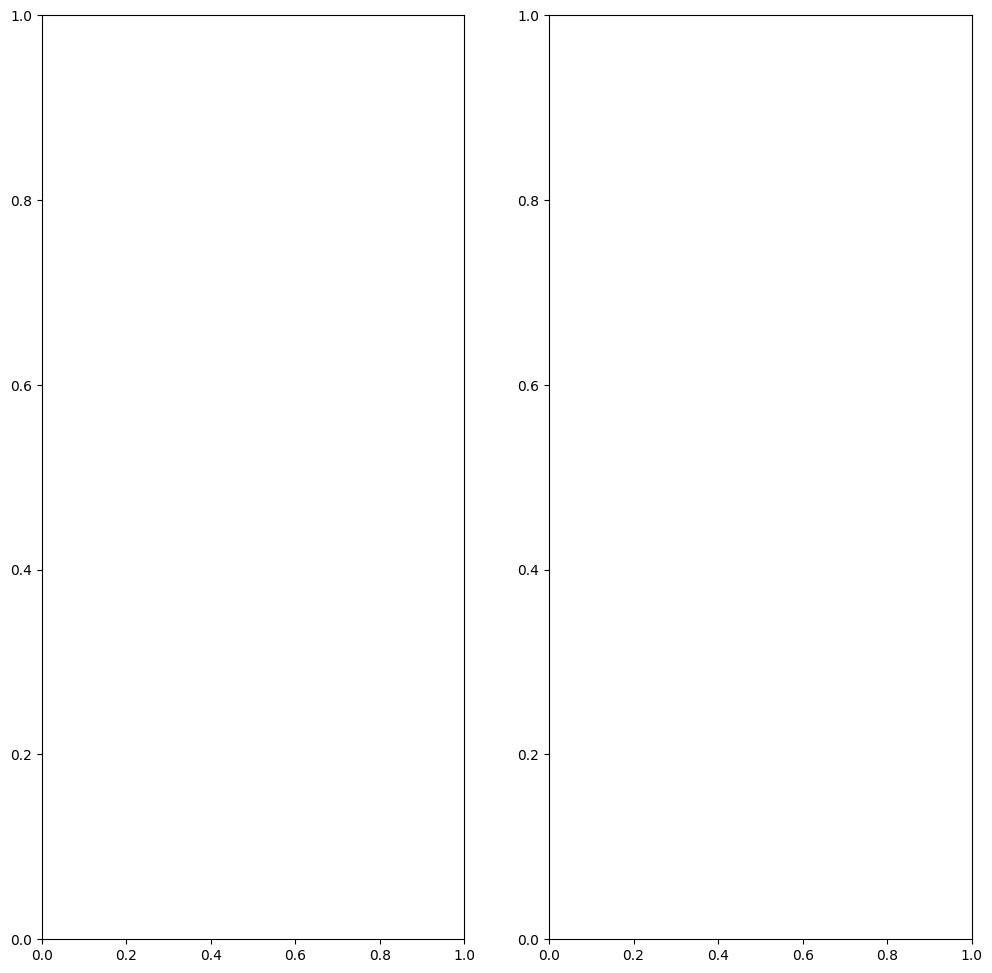

In [16]:
screen_res = (1080, 1920)
gray_value = 128  # mid-gray
sq_side = 224
sq_side_resized = 50
cap = cv2.VideoCapture(f"{paths['data_dir']}/stimuli/Project1917_movie_part1_24Hz.mp4")
h, w, frame_n = get_video_dimensions(cap)
offset_dims = ((screen_res[0] -h)//2 , ( screen_res[1] - w)//2)
resHor, resVer = 1920, 1080
canvas = None
cap.set(cv2.CAP_PROP_POS_FRAMES, int(5*23.98))
for idx, xy in enumerate(g):
    fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    if idx == 1000:
        break
    # canvas = pad_frame(v[round(5*23.98) + idx-1, :,:,:], movie_dims, offset_dims, canvas=canvas)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    canvas = pad_frame(frame, (h,w), offset_dims, canvas=None)
    # p = extract_circular_patch(canvas, xy[0], xy[1], 50, fill_value=128)
    p = extract_square_patch(canvas, xy[0], xy[1], sq_side)#, fill_value=128)
    resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)
    ax[0].imshow(canvas)
    ax[0].scatter(xy[0], xy[1], color='green')
    ax[0].set_xlim(0, resHor)
    ax[0].set_ylim(resVer, 0)
    # ax[1].imshow(canvas2)
    # # ax[1].scatter(xy[0], xy[1], color='green')
    # ax[1].set_xlim(0, resHor)
    # ax[1].set_ylim(resVer, 0)
    # assert np.array_equal(canvas2,canvas)
    ax[1].imshow(resized)
    plt.show()
    clear_output(wait=True)

In [102]:
round(5*23.98)

120

In [50]:
print(frame_count - len(g))


117.0


In [ ]:
frame_count/23

20955

In [52]:
117/5

23.4

In [38]:
5*23.98

119.9

In [ ]:
movie_part = 1
video_path = f"{paths['data_dir']}/stimuli/Project1917_movie_part{movie_part}_24Hz.mp4" 
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video file: {video_path}")
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# assert frame_count == len(g)

for idx, xy in enumerate(g):
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError(f"Failed to read frame {idx} from {video_path}")

    canvas = pad_frame(v[idx, :,:,:], movie_dims, offset_dims, canvas=canvas)
    p = extract_square_patch(canvas, xy[0], xy[1], sq_side)#, fill_value=128)
    resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)

AssertionError: 

In [34]:
with h5py.File("/Volumes/TIZIANO/models/Project1917_OFdir_run01_movie24Hz.mat", "r") as f:
    print(f.keys())



<KeysViewHDF5 ['fsVid', 'tVid', 'vecrep']>


In [ ]:
from scipy.io import loadmat
a = loadmat("/Volumes/TIZIANO/models/Project1917_real_alexnet_real_fc_layer2_run01_movie24Hz.mat")["vecrep"]

In [37]:
a.shape

(933, 20953)

In [ ]:
from einops import rearrange

In [51]:
v_vec = TimeSeries(rearrange(v, 'b h w c -> (h w c) b'), 23.98)
v_vec.resample(50)

In [56]:
for f in v_vec:
    f = f.reshape(522, 1280, 3)           
    plt.imshow(f)
    plt.show()
    clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
for idx, xy in enumerate(g):
    fig, ax = plt.subplots(1, 2)
    if idx == 200:
        break
    canvas = pad_frame(v[idx, :,:,:], movie_dims, offset_dims, canvas=canvas)
    # p = extract_circular_patch(canvas, xy[0], xy[1], 50, fill_value=128)
    p = extract_square_patch(canvas, xy[0], xy[1], sq_side)#, fill_value=128)
    resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)

In [24]:
200*200*3*20000*8/10**9

19.2